# Surface Mapping using Apriltags

In this notebook, we show how to use AprilTags to map from gaze-to screen coordinates. Along the way, we will also show some additional epoching functionalities.

To do so, we have collected a dataset where a participant freely views artworks presented on screen. Each artwork is shown for 4s, followed by a 0.5s inter trial intervall and a 0.5s central fixation cross. We can download this dataset using `get_sample_data()`.

In [14]:
from pyneon import Dataset, get_sample_data
import matplotlib.pyplot as plt

# Load a sample recording
dataset_dir = get_sample_data("markers", format="native")
dataset = Dataset(dataset_dir)

We have two recordings. One recording used AprilTags as markers and presented in total 40 images. The second recording used ArUco markers and presented in total 5 images. We will first focus on the AprilTag recording and later show how to use the ArUco markers for surface mapping with a similar workflow.

In [15]:
rec = dataset.recordings[1]
print(rec)


Data format: native
Recording ID: 83889080-158a-42c5-b7a1-a6e1298a1715
Wearer ID: 028e4c69-f333-4751-af8c-84a09af079f5
Wearer name: Pilot
Recording start time: 2026-01-27 16:27:10.887000
Recording duration: 38387000000 ns (38.387 s)



Let us take a closer look at the events file, populated with triggers sent during the initial viewing

We can see that the name column holds the information ofinterest to us. As the column ontains both information about the event_type as well as its name, we will first parse these apart. This process is a bit lengthy, but necessary to make sense of our data

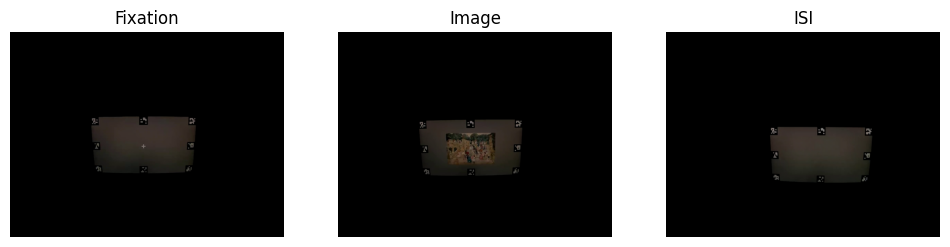

In [16]:
video = rec.scene_video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(150, ax=axs[0], show=False)
video.plot_frame(200, ax=axs[1], show=False)
video.plot_frame(300, ax=axs[2], show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.show()

In all of the frames shown above, we can see QR-code like markers at the borders of the screen. These are called apriltags and can be used as fiducial markers to relate video to real-world coordinates. PyNeon wraps a function that performs the detection of these. For computational efficiency, we only perform one detection every 30 frames.

In [17]:
detected_markers = video.detect_markers(
    "5x5_250", detection_window=(180, 210), detection_window_unit="frame"
)

Detecting markers: 100%|██████████| 31/31 [00:02<00:00, 10.66it/s]


ValueError: No marker detections found.

In [ ]:
detected_markers.data.loc[detected_markers.ts[0]]

In [ ]:
# Only get markers detected in frame
frame = 210
video.plot_detected_markers(detected_markers, frame_index=frame)

NameError: name 'video' is not defined

Having detected the markers (apriltags), we now need to provide information on the real-world coordinates of our markers. This is solved via a marker_info dataframe, which we generate below.

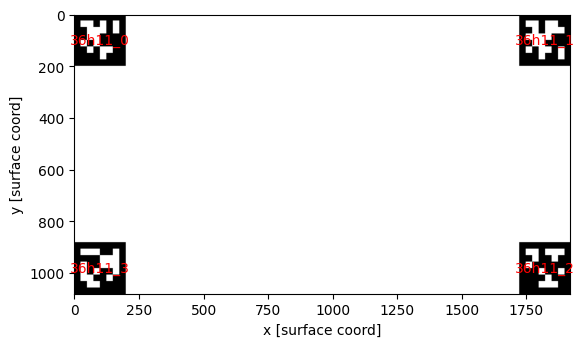

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='x [surface coord]', ylabel='y [surface coord]'>)

In [1]:
from pyneon.vis import plot_marker_layout
import pandas as pd

marker_layout = pd.DataFrame(
    {
        "marker name": [f"36h11_{i}" for i in range(4)],
        "size": 200,
        "center x": [100, 1820, 1820, 100],
        "center y": [100, 100, 980, 980],
    }
)

plot_marker_layout(marker_layout)

In [ ]:
print(marker_layout)

With this, we can now run the ``find_homograpghy()`` method. This method finds the map between the detections and the provided coordinates for each frame. As we did not do detections in every frame, we further provide the skip_frames as used before so that the homographies can be interpolated.

In [ ]:
# cast index to np.ndarray
index = rec.gaze.data.index.to_numpy()
print(index[:10])

In [ ]:
from pyneon.video import find_homographies

homographies = find_homographies(
    marker_layout,
    detected_markers,
)

with this, we can finally transform both gaze and fixation coordinates into the screen's reference frame:

In [ ]:
gaze_on_screen = rec.gaze_on_surface(homographies=homographies, overwrite=True)
fixations_on_screen = rec.fixations_on_surface(
    gaze_on_surface=gaze_on_screen, overwrite=True
)

In [ ]:
gaze_data = gaze_on_screen.data
fix_data = fixations_on_screen.data

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    gaze_data["gaze x [surface coord]"],
    gaze_data["gaze y [surface coord]"],
    s=1,
    alpha=0.5,
    c=gaze_data.index,
    cmap="viridis",
)

plt.scatter(
    fix_data["fixation x [surface coord]"],
    fix_data["fixation y [surface coord]"],
    s=1,
    c="black",
    label="Fixations",
)

plt.plot(
    [-600, 600, 600, -600, -600],
    [-400, -400, 400, 400, -400],
    color="red",
    label="Image outline",
)

plt.xlabel("X Coordinate (surface coord)")
plt.ylabel("Y Coordinate (surface coord)")

plt.xlim(-800, 800)
plt.ylim(-600, 600)